In [183]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [185]:
# read the data
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')
df = df.head(500)
df.shape

(500, 10)

## EDA

Text(0.5, 0, 'Review Stars')

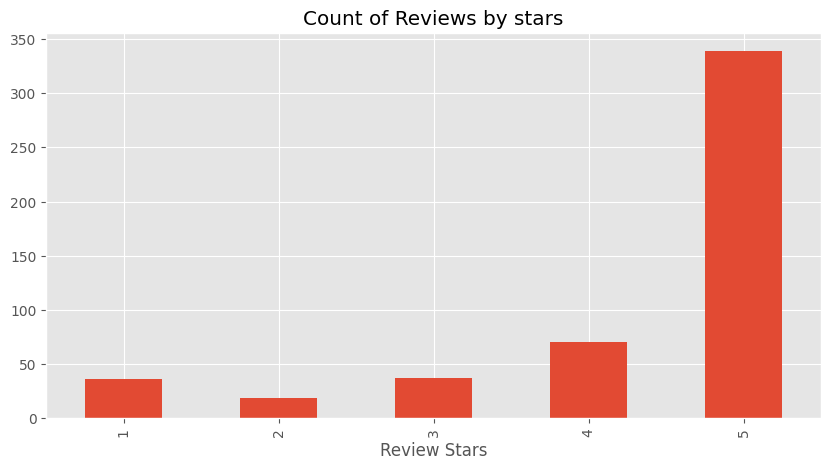

In [186]:
ax = df['Score'].value_counts().sort_index()\
.plot(kind='bar', 
      title='Count of Reviews by stars',
      figsize=(10,5))

ax.set_xlabel('Review Stars')


## NLTK

In [187]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [188]:
tokens = nltk.word_tokenize(example)
tokens

['This',
 'oatmeal',
 'is',
 'not',
 'good',
 '.',
 'Its',
 'mushy',
 ',',
 'soft',
 ',',
 'I',
 'do',
 "n't",
 'like',
 'it',
 '.',
 'Quaker',
 'Oats',
 'is',
 'the',
 'way',
 'to',
 'go',
 '.']

In [189]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [190]:
entities = nltk.chunk.ne_chunk(tagged) # chink it into sentence
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1 VADER 
(valence aware dictionary and sentiment reasoner) bag of Words approach
* stop words are removed
* each word is scored amd combined to a total score

Uses SentimentIntensityAnalyzer to get the neg/nue/pos of the text

In [191]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [192]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [193]:
sia.polarity_scores('This is the worst thing ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [194]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [195]:
# run the polarity score on entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)



  0%|          | 0/500 [00:00<?, ?it/s]

In [196]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [197]:
# sentiment score and meta data
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADERS result

Text(0.5, 1.0, 'Compound Score by amazon star Review')

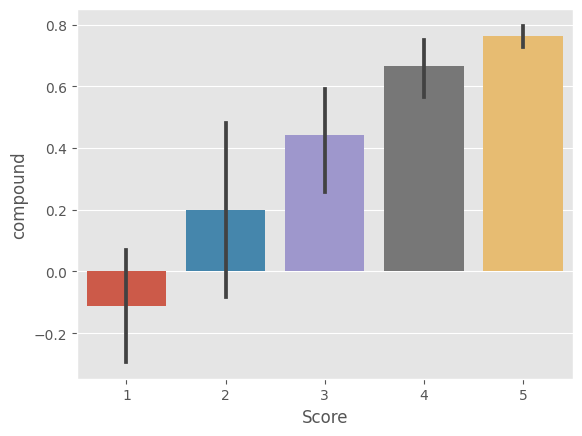

In [198]:
sns.barplot(data=vaders, x='Score', y= 'compound')
ax.set_title('Compound Score by amazon star Review')


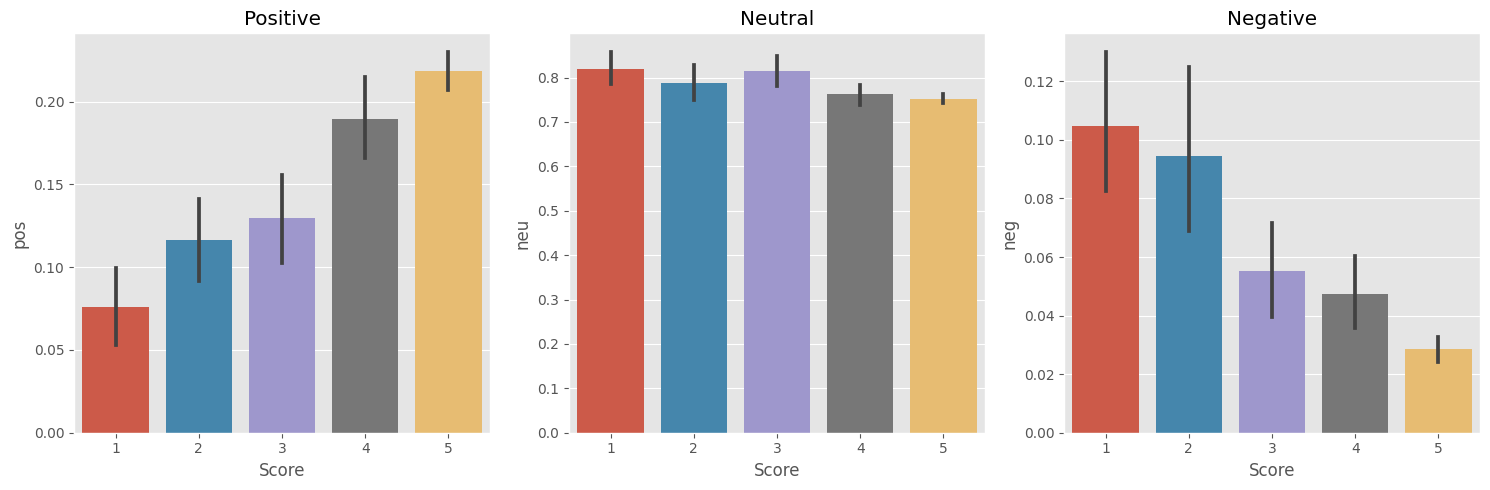

In [199]:
from matplotlib.pyplot import subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()


## Roberta Pretrained Model
* use a modle trained of a large corpus of data
* Transformer model accounts for the words bu also the context related to other words

In [200]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [201]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [202]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [203]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dic ={
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[1] 
}
print(scores_dic)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687466, 'roberta_pos': 0.020687466}


In [204]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dic ={
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[1] 
}
    return scores_dic

In [205]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_res = sia.polarity_scores(text)
        vader_res_rename ={}
        for key, value in vader_res.items():
            vader_res_rename[f'vader_{key}']= value

        roberts_result = polarity_scores_roberta(text)
        both = {**vader_res_rename, **roberts_result}
        res[myid]=both
    except RuntimeError:
        print(f'Broke for id{myid}: ')
   
    


  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id83: 
Broke for id187: 


In [206]:
result_df = pd.DataFrame(res).T
result_df = result_df.reset_index().rename(columns={'index': 'Id'})
result_df = result_df.merge(df, how='left')

In [207]:
result_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.049980,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,0.508986,0.452414,0.452414,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.098067,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.090219,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.010302,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [208]:
result_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [209]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

## Step 3 Combine and Compare

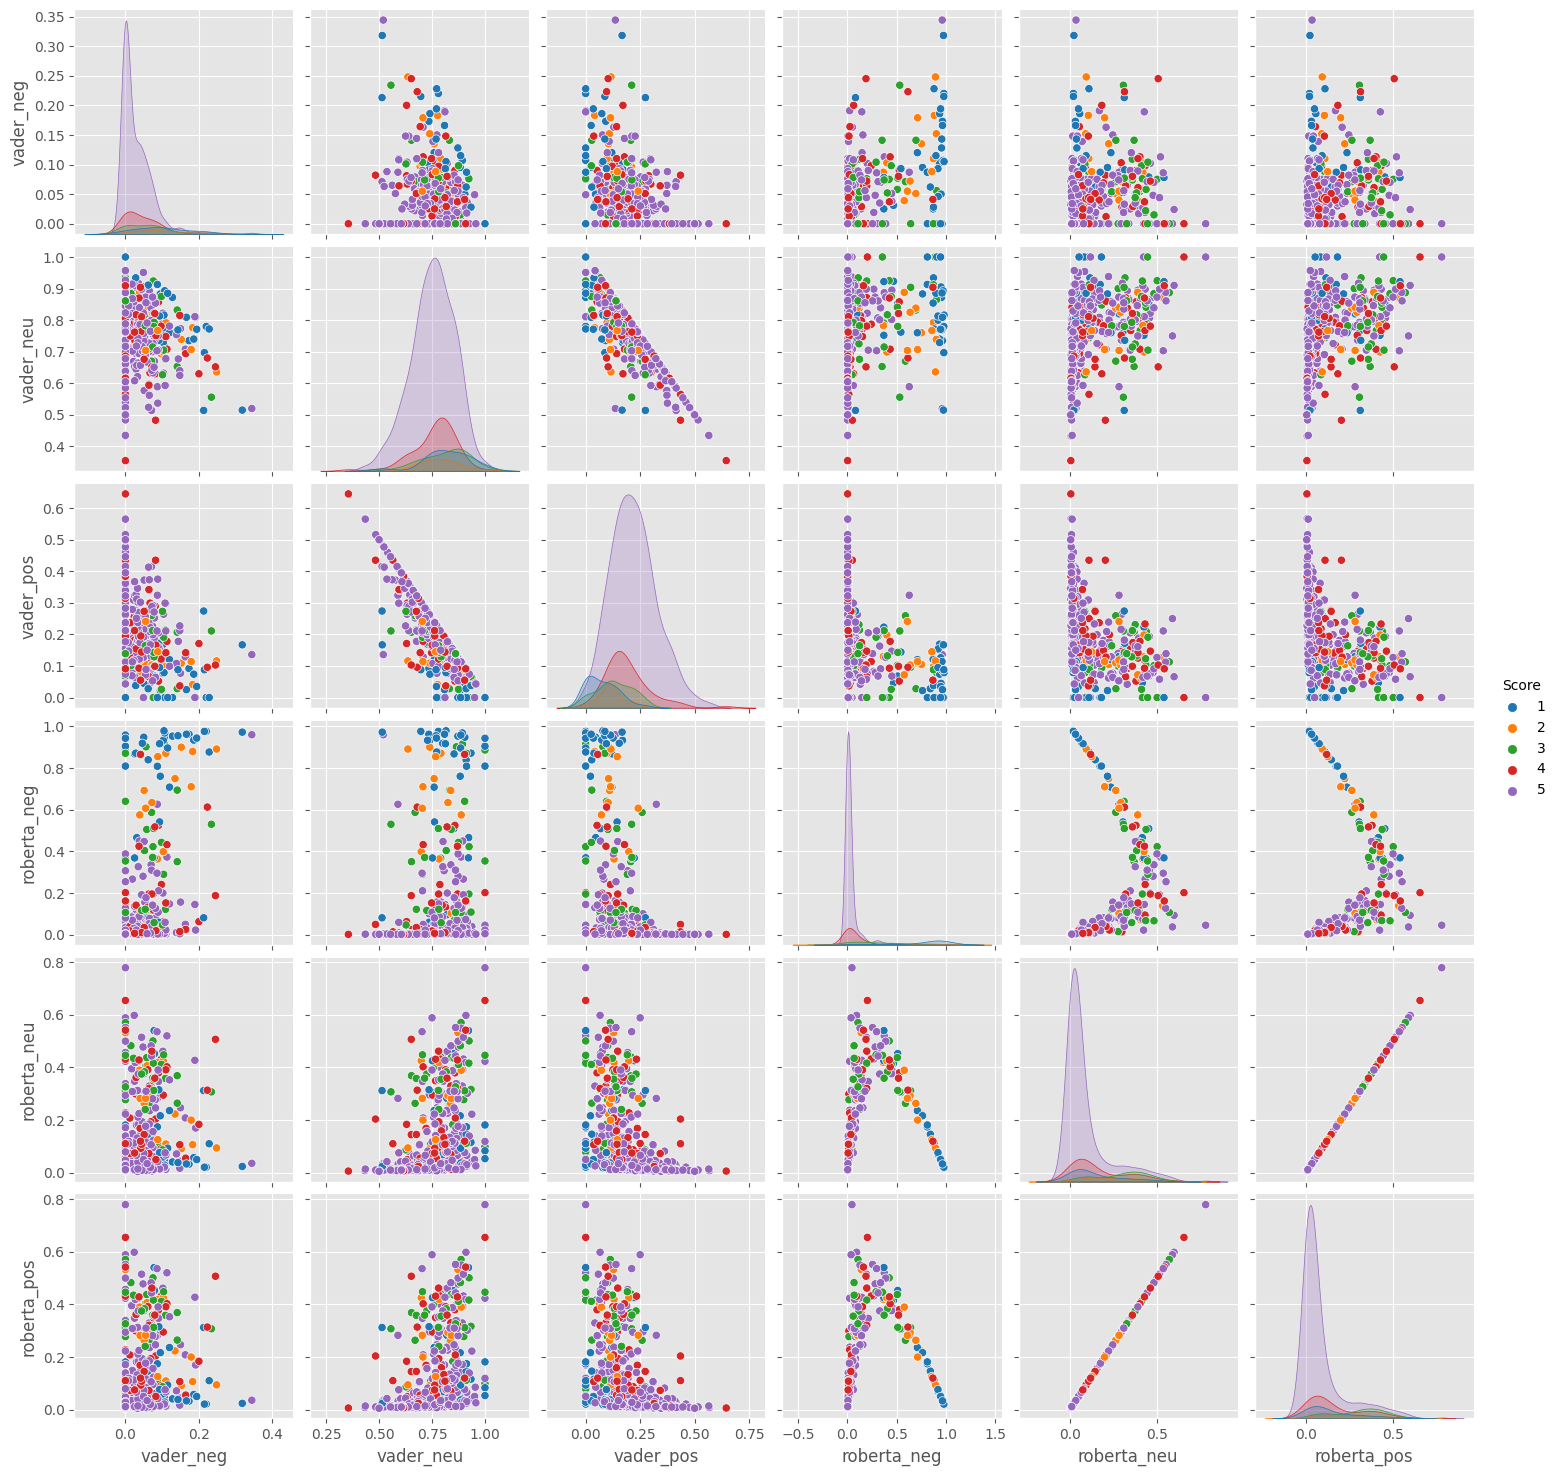

In [210]:
sns.pairplot(data=result_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'], 
             hue='Score',
             palette='tab10')

## Step 4: Review Examples:
*  Positive 1-star and Negetive 5-star reviews  
lets look at some examples where the model scoring and rewin score differ the most

In [211]:
result_df.query('Score == 1').sort_values('roberta_pos', ascending = False)['Text'].values[0]

'Hey, the description says 360 grams - that is roughly 13 ounces at under $4.00 per can. No way - that is the approximate price for a 100 gram can.'

In [212]:
result_df.query('Score == 1').sort_values('vader_pos', ascending = False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [213]:
# Negative sentiment 5-star review
result_df.query("Score == 5").sort_values('roberta_neg',ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [214]:
# Negative sentiment 5-star review vader
result_df.query("Score == 5").sort_values('vader_neg',ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## The Trasnforers Pipeline


In [215]:
from transformers import pipeline
sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [216]:
sent_pipeline('I love sandwige')

[{'label': 'POSITIVE', 'score': 0.999754011631012}]

In [218]:
sent_pipeline('I could not enjoy that movie' )

[{'label': 'NEGATIVE', 'score': 0.9983075857162476}]

In [222]:
sent_pipeline('hm')

[{'label': 'NEGATIVE', 'score': 0.8657911419868469}]